In [2]:
%load_ext autoreload
%autoreload 2

# Generating samples and parsing parameters scan file



In [3]:
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
from GENE_ML.gene_ml.runners.GENErunner import GENErunner
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

import os
import sys
sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))


parameters = ['box-kymin', '_grp_species_1-omt', '_grp_species_0-omt', 'species-omn', 'geometry-q0', 'geometry-shat', 'general-beta']
bounds = [(0.05,1), (10,70), (10,70), (5,60), (3,6), (0.001,4), (0.1E-2,0.4E-2)]

#Working fine
# parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# bounds = [(0.05,1), (10,70), (5,60)]

num_samples = 5000
sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

##Parser
#The parsers main function is write_input_file
# wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
#  It will then create a parameters file that can scan over all the points.
base_params_path = os.path.join(os.getcwd(),'parameters_base_dp')
remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/5000s_7p'
parser = GENE_scan_parser(base_params_path, remote_save_dir)

## Runner
#The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# code_run will take the set of points named samples and parse them into a parameters file.
#  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
remote_run_dir = '/project/project_462000451/gene_auto/'
host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
sbatch_base_path = os.path.join('sbatch_base_dp')
guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
runner = GENErunner(parser, remote_run_dir, host, sbatch_base_path, guess_sample_wallseconds)

##Executor
#The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# The executor should alter a base batch script to account for that less samples will be ran. 
num_workers = 20
executor = ScanExecutor(num_workers, sampler, runner)
# if project == 'UQ':
#     #UQ
#     ##Sampler args dependant on sampler chosen
#     parameters = ['box-kymin', '_grp_species_0-omt', '_grp_species_1-omt']
#     bounds = [(0.1,100.0),(2,3.5), (4,6.75)]
#     ##Parser args
#     base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')


#Sampling the data

TypeError: ScanExecutor.__init__() missing 1 required positional argument: 'remote_save_dir'

In [ ]:
# executor.start_runs()

# Pulling Scanlog from Lumi 

In [4]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
import os
host = 'lumi'
data_name = '5000s_7p'
test_percentage = 50

if os.path.isdir(f'scanlogs/{data_name}'):
    ## If the data is already loaded from the remote to local .../scanlogs/<data_name> then the host and remote path can be ommitted
    data_set = ScanData(data_name, parser, test_percentage=test_percentage)
else:
    data_set = ScanData(data_name, parser, host, remote_path=remote_save_dir, test_percentage=test_percentage)

Initialising dataset

LOADING SCANLOG/S

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___0.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___1.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___10.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___11.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___12.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___13.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___14.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___15.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___16.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scanlogs/5000s_7p/scan___17.log

LOADING SCANLOG INTO PYTHON /home/marcin/local/DEEPlasma/scan

# Making Surrogate Model and Visualising Performance

# SVM

In [45]:

#imports
from GENE_ML.gene_ml.models.SVM import SVM


#Sampling already done, gene has been ran
#data_set = ScanData(name='100_3p', test_percentage=3)
svm = SVM()
svm.train(data_set.x_train, data_set.growthrate_train)

growthrate_predict_seen = svm.predict(data_set.x_train)
growthrate_predict_unseen = svm.predict(data_set.x_test)

NO UNCERTAINTY PROVIDED
NO UNCERTAINTY PROVIDED


/tmp/ipykernel_25496/3904745455.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_residuals.show()


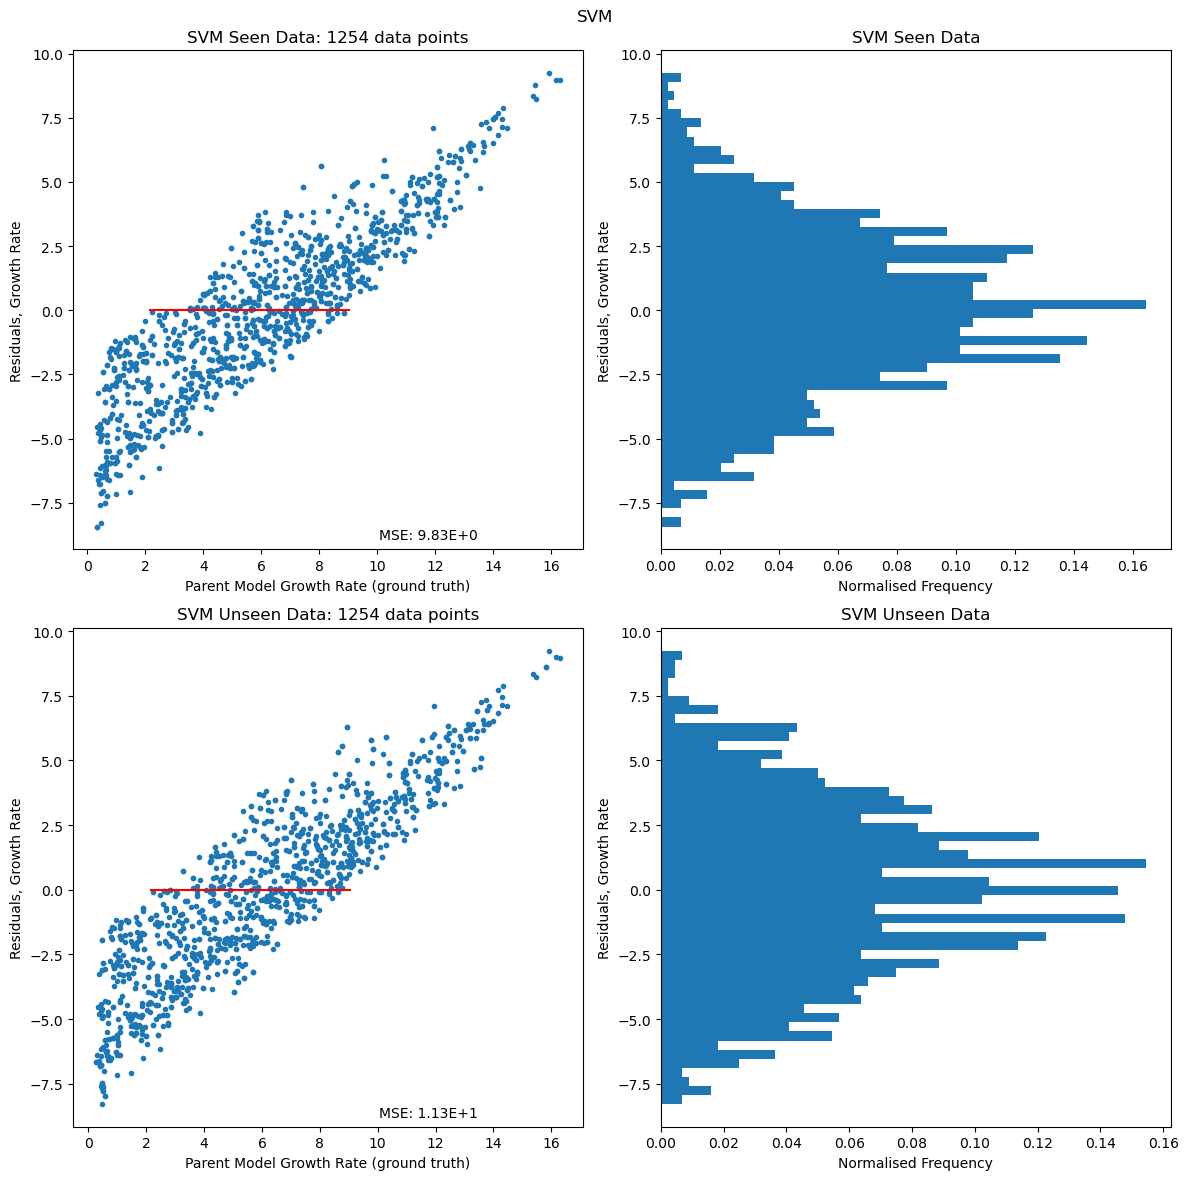

In [46]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis
model_name = 'SVM'
ncol=2
nrow=2
size=6
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

fig_residuals.suptitle('SVM')
fig_residuals.tight_layout()
fig_residuals.show()

# GPR 5000s_7p

In [105]:
import os
import matplotlib.pyplot as plt
from GENE_ML.gene_ml.dataset.ScanData import ScanData
# #data_set = ScanData('3560_3p', ssh_path='lumi:$out/ped2_safescan/scanfiles0012/scan.log', test_percentage=50)
# data_set = ScanData('3560_3p', test_percentage=50)

#imports
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml import visualise as vis
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
results_gpr_name = 'results_5000s_7p_gpr_50tp' #
results_gpr = Results(results_gpr_name)

if os.path.exists(results_gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    data_set = ScanData(name='5000s_7p', parser=parser, test_percentage=50)
    gpr = GPR()
    gpr.train(data_set.x_train, data_set.growthrate_train)
    gpr.tune_hypers(data_set.x_train, data_set.growthrate_train)

    results_gpr.growthrate_predict_seen, results_gpr.growthrate_predict_seen_errors = gpr.predict(data_set.x_train)
    results_gpr.growthrate_predict_unseen, results_gpr.growthrate_predict_unseen_errors = gpr.predict(data_set.x_test)

    results_gpr.save()

ModuleNotFoundError: No module named 'GPy'

In [ ]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', y_pred_err=results_gpr.growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', y_pred_err=results_gpr.growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()


# NN

In [52]:
from GENE_ML.gene_ml.models.NN import NN
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

train_batch_size = 32

nn = NN()

scalerX = MinMaxScaler()
X_normalized = scalerX.fit_transform(data_set.x_train)
X_normalized = torch.Tensor(X_normalized)

X_val_normalized = scalerX.transform(data_set.x_test)
X_val_normalized = torch.Tensor(X_val_normalized)

scalerY = MinMaxScaler()
Y_normalized = scalerY.fit_transform(data_set.growthrate_train.reshape(-1,1))
Y_normalized = torch.Tensor(Y_normalized)

Y_val_normalized = scalerY.transform(data_set.growthrate_test.reshape(-1,1))
Y_val_normalized = torch.Tensor(Y_val_normalized)

training = TensorDataset(X_normalized,Y_normalized)
val = TensorDataset(X_val_normalized,Y_val_normalized)

train_dataloader = DataLoader(dataset = training, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(dataset = val, batch_size = 32, shuffle=False)

nn.train(train_dataloader, val_dataloader, 10000, train_batch_size)

predict_seen = nn.predict(X_normalized)
predict_seen = scalerY.inverse_transform(predict_seen.detach().numpy())
predict_seen = predict_seen.squeeze()

X_unseen_normalized = scalerX.transform(data_set.x_test)
X_unseen_normalized = torch.Tensor(X_unseen_normalized)
predict_unseen = nn.predict(X_unseen_normalized)
predict_unseen = scalerY.inverse_transform(predict_unseen.detach().numpy())
predict_unseen = predict_unseen.squeeze()


--------------------------------
Epoch 1: loss=0.051334, val_loss=0.026128


--------------------------------
Epoch 2: loss=0.017916, val_loss=0.010241


--------------------------------
Epoch 3: loss=0.008089, val_loss=0.007327


--------------------------------
Epoch 4: loss=0.006188, val_loss=0.005137


--------------------------------
Epoch 5: loss=0.005388, val_loss=0.006889


--------------------------------
Epoch 6: loss=0.004869, val_loss=0.005469


--------------------------------
Epoch 7: loss=0.004500, val_loss=0.005011


--------------------------------
Epoch 8: loss=0.004604, val_loss=0.003932


--------------------------------
Epoch 9: loss=0.003702, val_loss=0.003559


--------------------------------
Epoch 10: loss=0.003407, val_loss=0.003078


--------------------------------
Epoch 11: loss=0.002974, val_loss=0.002839


--------------------------------
Epoch 12: loss=0.002598, val_loss=0.002395


--------------------------------
Epoch 13: loss=0.002306, val_loss=0.0032

NO UNCERTAINTY PROVIDED
NO UNCERTAINTY PROVIDED


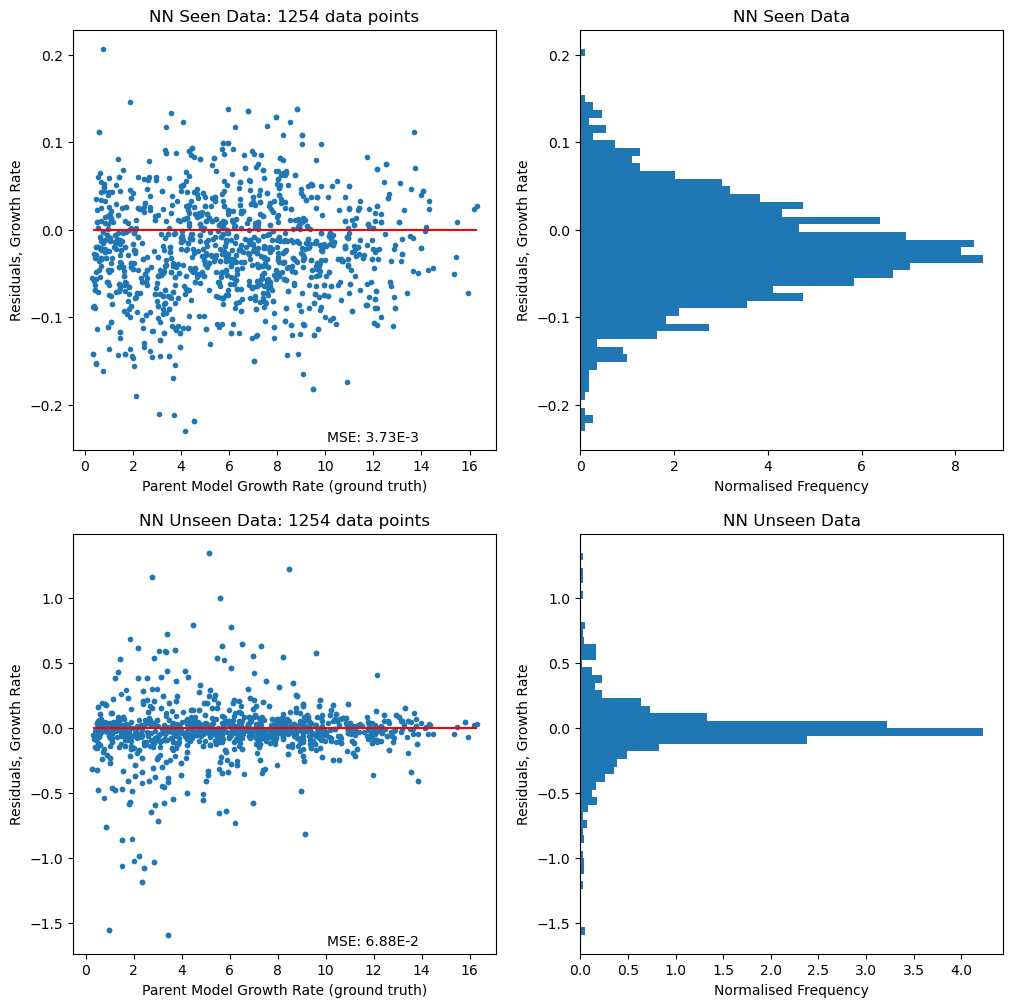

In [53]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol = 2
nrow = 2
size = 6
model_name = 'NN'

fig_residuals, [[ax1,ax2], [ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')
